# Import required packages

In [9]:
import xarray as xr                                                  # handles gridded data
import numpy as np                                                   # numerical functions etc
import pandas as pd                                                  # handles tables of data (.csv, spreadsheets etc)
import re                                                            # allows manipulation of text strings

import matplotlib                                                    # plotting functions generally
import matplotlib.pyplot as plt                                      # specific plotting function we'll use a lot, so we'll give it a shorter name
from matplotlib.patches import Rectangle                             # specific plotting function with an annoyingly long name

import statsmodels.nonparametric.smoothers_lowess as sm_lowess       # nonparametric smoother

import cartopy                                                       # plotting geographical features
import regionmask                                                    # convert shapefile to binary 0,1 mask
import geopandas as gpd                                              # shapefiles

from geopy.geocoders import Nominatim                                # get lat & lon coordinates from a place name
from dateutil.relativedelta import relativedelta                     # calculate differences in times (needed to decode weird timestamps)

# you might get an error like 'ERROR 1: PROJ: proj_create_from_database: Open of /rds/general/user/cb2714/home/anaconda3/envs/wwa/share/proj failed' - you can ignore this!

# Useful functions

In [10]:
def wrap_lon(ds):
    
    # 'wrap' longitudes from (0,360) to (-180,180) & sort into ascending order
    
    if "longitude" in ds.coords:
        lon = "longitude"
        lat = "latitude"
    elif "lon" in ds.coords:
        lon = "lon"
        lat = "lat"
    else: 
        # can only wrap longitude
        return ds
    
    if ds[lon].max() > 180:
        ds[lon] = (ds[lon].dims, (((ds[lon].values + 180) % 360) - 180), ds[lon].attrs)
        
    if lon in ds.dims:
        ds = ds.reindex({ lon : np.sort(ds[lon]) })
        ds = ds.reindex({ lat : np.sort(ds[lat]) })
    return ds

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def decode_times(ts):
    
    # manually decode times
    
    inc = re.sub(" .+", "", ts.time.units)
    startdate = pd.Timestamp(re.sub(".+since ", "", ts.time.units)+' 00:00:00.000000').to_pydatetime()
    
    if inc == "years":
        new_times = [np.datetime64(startdate + relativedelta(years = i)) for i in ts.time.values]
    elif inc == "months":
        new_times = [np.datetime64(startdate + relativedelta(months = i)) for i in ts.time.values]
    elif inc == "days":
        new_times = [np.datetime64(startdate + relativedelta(days = i)) for i in ts.time.values]
    elif inc == "hours":
        new_times = [np.datetime64(startdate + relativedelta(hours = i)) for i in ts.time.values]
    else:
        print("TBD: " +inc)
        return
        
    ts = ts.assign_coords(time = new_times)
    
    return ts

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def get_latlon(city):
    
    # retrieve lat & lon for given place name
    location = Nominatim(user_agent="GetLoc").geocode(city)
    if location is None:
        return {"lon" : None, "lat" : None}
    else:
        return {"lon" : location.longitude, "lat" : location.latitude}
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def doy_axes(ax = None):

    # make nicer axis labels when you're plotting against day of year
    if ax is None: ax = plt.gca()
    
    # define axis labels for DOY plotting
    days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
    lineticks = [i+1 for i in range(366) if (days[i].day) == 1]
    labelticks = [i+1 for i in range(366) if (days[i].day) == 16]
    labels = [days[i].strftime("%b") for i in range(366) if (days[i].day) == 16]

    # actually draw the axes & gridlines
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.1, lw = 1) for x in lineticks]
    ax.set_xlabel("")

In [11]:
# load the data and select just the total precipitation (tp), call it 'ds'
ds = xr.open_dataset("era5_tp_daily_eu_extended_10.7-25E_46-52.3N_1950-2024_su.nc").tp

# Exercises to practise working with gridded data

## Making a map for a single day

The `xarray` package can produce nice maps without much user input, but you can also customise them to show the features you're most interested in.  
Modify the code below to show one of the days during Storm Boris in mid-September, and choose a colour scheme and range of values that highlights the severity of the event.
Modify the label on the scale bar to say 'Precipitation (mm/day)'.

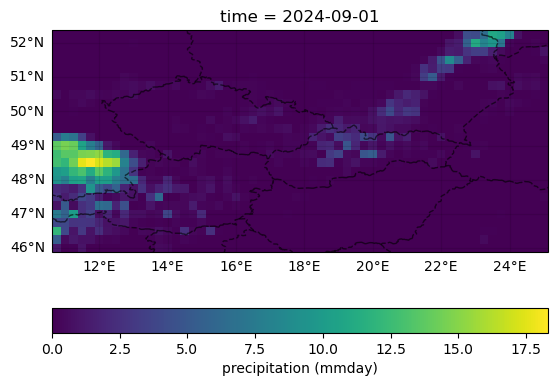

In [12]:
fig = ds.sel(time = "2024-09-01").plot(subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, 
                                       cbar_kwargs = {"location" : "bottom", "label" : "precipitation (mmday)"})

ax = fig.axes   # give the panel a name so we can add extra elements to it

ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

## Plotting several days 

We've been looking at Storm Boris but there was also extensive flooding in the same area in July 1997.  
- Modify the code to identify the 4 wettest days in July 1997 and customise the plot as you did above.  
- Modify the code to show 4 panels on each row, not 3
- If you're feeling brave, try resizing the colourbar by modifying the 'fraction' and 'pad' values in cbar_kwargs (run ?plt.colorbar in an empty cell to find out what the options do)

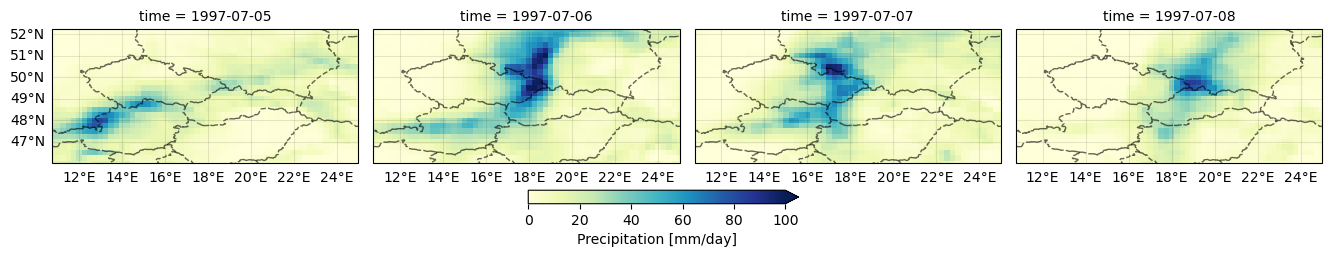

In [21]:
fig = ds.sel(time = slice("1997-07-05", "1997-07-08")).plot(cmap = "YlGnBu",  
                                                            vmin = 0, vmax = 100,
                                                            subplot_kws = {"projection" : cartopy.crs.PlateCarree(), 
                                                                           "extent" : (ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max()) # make sure the plot shows the right area
                                                                          },  
                                                            cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.1}, # move & resize the colourbar
                                                            col = "time",
                                                            col_wrap = 4)
# tidy up the axes
for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1)

for ax in fig.axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])
for ax in fig.axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])

### Making nicer titles for the panels
The default title format is '{coord} = {value}', where 'coord' is the dimension we're plotting over (in this case, time) and 'value' is the value of that dimension for that panel.  
We can set custom titles either by formatting the 'value' string differently, or by providing completely new titles.  
Experiment with the examples below and try making your own titles for each panel.  
You could also add an overall title (look for 'suptitle' in the original notebook).

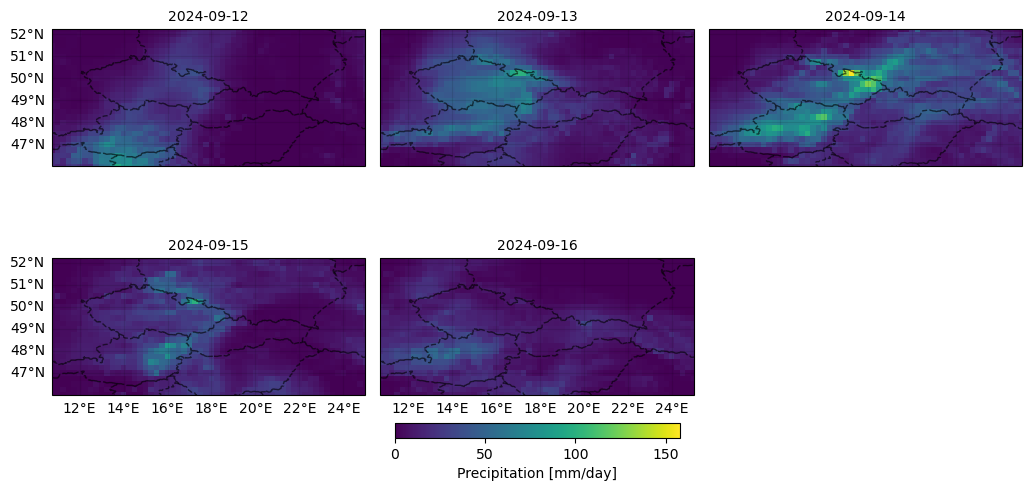

In [22]:
# copy your plot function from the cell above to replicate the plots here
fig = ds.sel(time = slice("2024-09-12", "2024-09-16")).plot(subplot_kws = {"projection" : cartopy.crs.PlateCarree(), 
                                                                           "extent" : (ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max()) # make sure the plot shows the right area
                                                                          },  
                                                            cbar_kwargs = {"location" : "bottom", "fraction" : 0.025, "pad" : 0.05}, # move & resize the colourbar
                                                            col = "time",
                                                            col_wrap = 3)
# tidy up the axes
for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1)

for ax in fig.axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])
for ax in fig.axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])


# add # at the beginning of the row(s) to switch off the options you don't want to use
# delete the # to switch on the option you do want (if you leave more than one option 'on' then python will use the last one)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# just use the date as the title for each panel
fig.set_titles(template = "{value}") 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# # manually set text strings for the titles (make sure you make as many titles as there are panels!)
# titles = ["day 1", "day 2", "day 3"]
# for ax, title in zip(fig.axs.flat, titles):
#     ax.set_title(title)

## Calculating an anomaly
Previously we calculated an anomaly with respect to September rainfall only.  
We might also want to compare to the average rainfall during the wet season (approx. May-September in this region).  
The example below selects all months from June-August: modify it to select all days during the rainy season, then calculate the daily mean rainfall over those months from 1990-2020.  



In [23]:
# select just the months of the rainy season
ds_rainyseason = ds.sel(time = ds.time.dt.month.isin([5,6,7,8,9]))

# calculate the mean daily rainfall from 1990-2020
ds_clim = ds_rainyseason.sel(time = slice("1990", "2020")).mean("time")

# calculate thedaily anomalies with respect to this climatology
ds_anom = ds - ds_clim

Now plot the anomalies during Storm Boris (you'll need to customise the plots as before)

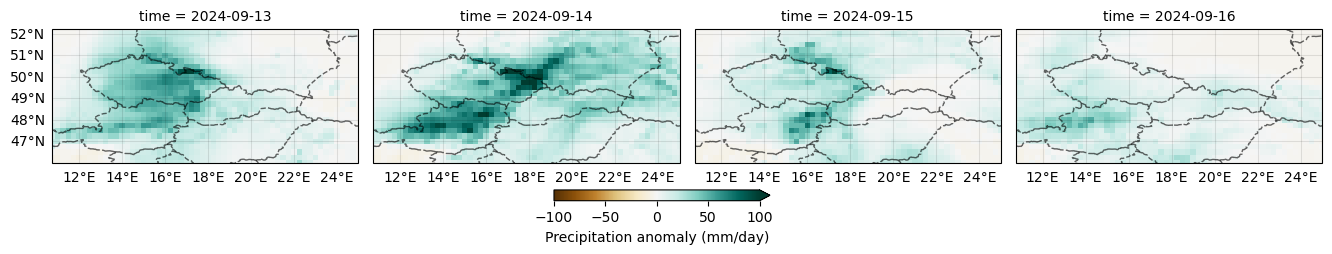

In [28]:
# the colour scale above isn't a great choice for anomalies - we should use a divergent colourmap (Python will suggest a default)
fig = ds_anom.sel(time = slice("2024-09-13", "2024-09-16")).plot(cmap = "BrBG", vmin = -100, vmax = 100,
                                                                 subplot_kws = {"projection" : cartopy.crs.PlateCarree(),
                                                                                "extent" : (ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max())}, 
                                                    cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.1, "label" : "Precipitation anomaly (mm/day)"},
                                                    col = "time",
                                                    col_wrap = 4)

for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1)

for ax in fig.axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])
for ax in fig.axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])

Now make a copy of the cell above and do the same for the 1997 storm

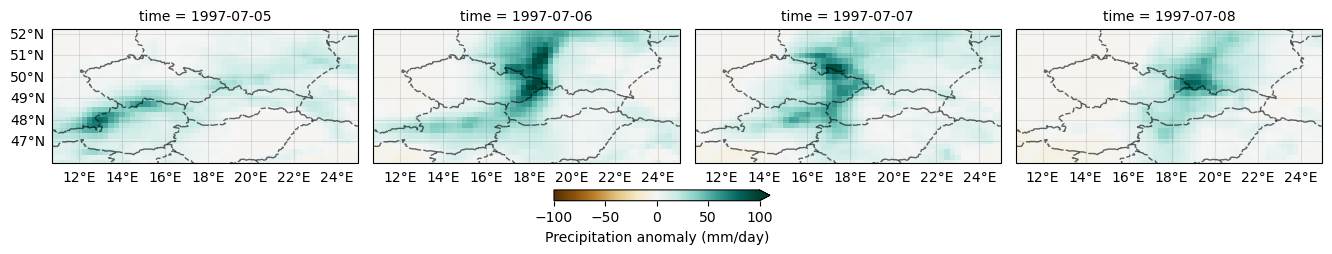

In [33]:
# the colour scale above isn't a great choice for anomalies - we should use a divergent colourmap (Python will suggest a default)
fig = ds_anom.sel(time = slice("1997-07-05", "1997-07-08")).plot(cmap = "BrBG", vmin = -100, vmax = 100,
                                                                 subplot_kws = {"projection" : cartopy.crs.PlateCarree(),
                                                                                "extent" : (ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max())}, 
                                                    cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.1, "label" : "Precipitation anomaly (mm/day)"},
                                                    col = "time",
                                                    col_wrap = 4)

for ax in fig.axs.flat:
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.6)
    ax.gridlines(color = "k", alpha = 0.1)

for ax in fig.axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])
for ax in fig.axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])